In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.vision import (ImageList, PointsItemList, get_transforms, ResizeMethod, open_image, Tensor, 
                           tensor, Image, imagenet_stats, Flatten, cnn_learner, models, Path)
from fastai.callbacks import SaveModelCallback, EarlyStoppingCallback
from fastprogress import progress_bar
import numpy as np
import pandas as pd
import torch.nn as nn
from torch.nn.functional import mse_loss

In [3]:
images_path = '../data/resized_images'
labels_path = '../data/resized_labels.csv'
target_size = 320

In [4]:
y = pd.read_csv(labels_path, index_col='filename')

In [5]:
def get_y_func(x):
    filename = str(x).split('/')[-1]
    coord_list = []
    coords = list(y.loc[filename])
    for i in range(len(coords)//2):
        coord_list.append([coords[i*2+1],coords[i*2]])
    return tensor(coord_list)

In [6]:
transforms = get_transforms(
    do_flip=False,
    max_rotate=45, 
    max_zoom=1.5, 
    max_lighting=0.5, 
    max_warp=0.4, 
    p_affine=1., 
    p_lighting=1.
) 

In [7]:
data = (
    PointsItemList
        .from_folder(images_path)
        .split_by_rand_pct(0.15)
        .label_from_func(get_y_func)
        .transform(
            transforms,
            size=320,
            tfm_y=True, 
            remove_out=False, 
            padding_mode='reflection', 
            resize_method=ResizeMethod.PAD
        )
        .databunch()
        .normalize(imagenet_stats)
)

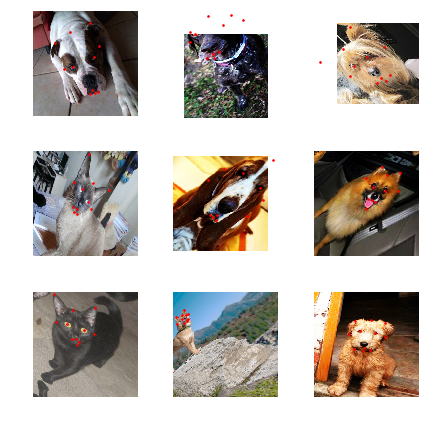

In [8]:
data.show_batch(3, figsize=(6,6))

In [9]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

In [10]:
head_reg = nn.Sequential(
    Flatten(), 
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(51200, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256, 22),
    Reshape(-1,11,2),
    nn.Tanh()
)

In [11]:
class MSELossFlat(nn.MSELoss):
    def forward(self, input:Tensor, target:Tensor):
        return super().forward(input.view(-1), target.view(-1)) 

mse_loss_flat = MSELossFlat()

learn = cnn_learner(
    data, 
    models.resnet34, 
    loss_func=mse_loss_flat,
    custom_head=head_reg
).to_fp16()

In [12]:
learn.path = Path('..')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


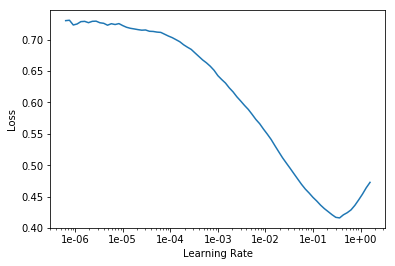

In [13]:
learn.lr_find()
learn.recorder.plot()

In [14]:
learn.freeze_to(-1)
learn.fit_one_cycle(
    10, 
    slice(1e-2), 
    callbacks=[
        SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='fastai_resnet34_2'),
        EarlyStoppingCallback(learn, monitor='valid_loss', min_delta=0.01, patience=10)
    ]
)

epoch,train_loss,valid_loss,time
0,0.263345,0.055270,00:41
1,0.119564,0.021613,00:41
2,0.080564,0.018030,00:41
3,0.084002,0.017466,00:41
4,0.061506,0.013600,00:41
5,0.055497,0.011157,00:42
6,0.051399,0.009509,00:42
7,0.046244,0.009001,00:41
8,0.057721,0.008381,00:41
9,0.047920,0.008721,00:41


Better model found at epoch 0 with valid_loss value: 0.05527002736926079.
Better model found at epoch 1 with valid_loss value: 0.02161283977329731.
Better model found at epoch 2 with valid_loss value: 0.018029671162366867.
Better model found at epoch 3 with valid_loss value: 0.017466403543949127.
Better model found at epoch 4 with valid_loss value: 0.013599919155240059.
Better model found at epoch 5 with valid_loss value: 0.011157190427184105.
Better model found at epoch 6 with valid_loss value: 0.009508823975920677.
Better model found at epoch 7 with valid_loss value: 0.009000971913337708.
Better model found at epoch 8 with valid_loss value: 0.008381430990993977.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


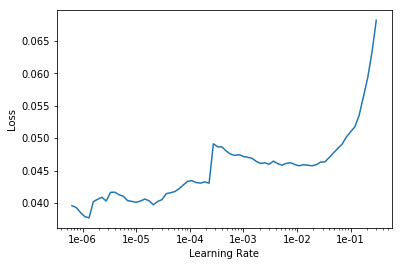

In [15]:
learn.lr_find()
learn.recorder.plot()

In [16]:
learn.freeze_to(-2)
learn.fit_one_cycle(
    10, 
    slice(1e-2/2), 
    callbacks=[
        SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='fastai_resnet34_2'),
        EarlyStoppingCallback(learn, monitor='valid_loss', min_delta=0.01, patience=10)
    ]
)

epoch,train_loss,valid_loss,time
0,0.056960,0.010999,00:47
1,0.049749,0.011872,00:46
2,0.054350,0.016511,00:47
3,0.051875,0.012137,00:46
4,0.047873,0.021807,00:46
5,0.044724,0.013232,00:46
6,0.169297,0.007668,00:46
7,0.066724,0.006577,00:47
8,0.048023,0.006062,00:47
9,0.039529,0.005981,00:47


Better model found at epoch 0 with valid_loss value: 0.010999195277690887.
Better model found at epoch 6 with valid_loss value: 0.007668278645724058.
Better model found at epoch 7 with valid_loss value: 0.006576957646757364.
Better model found at epoch 8 with valid_loss value: 0.006061504129320383.
Better model found at epoch 9 with valid_loss value: 0.005981155205518007.


In [15]:
# learn.load('../models/fastai_model')

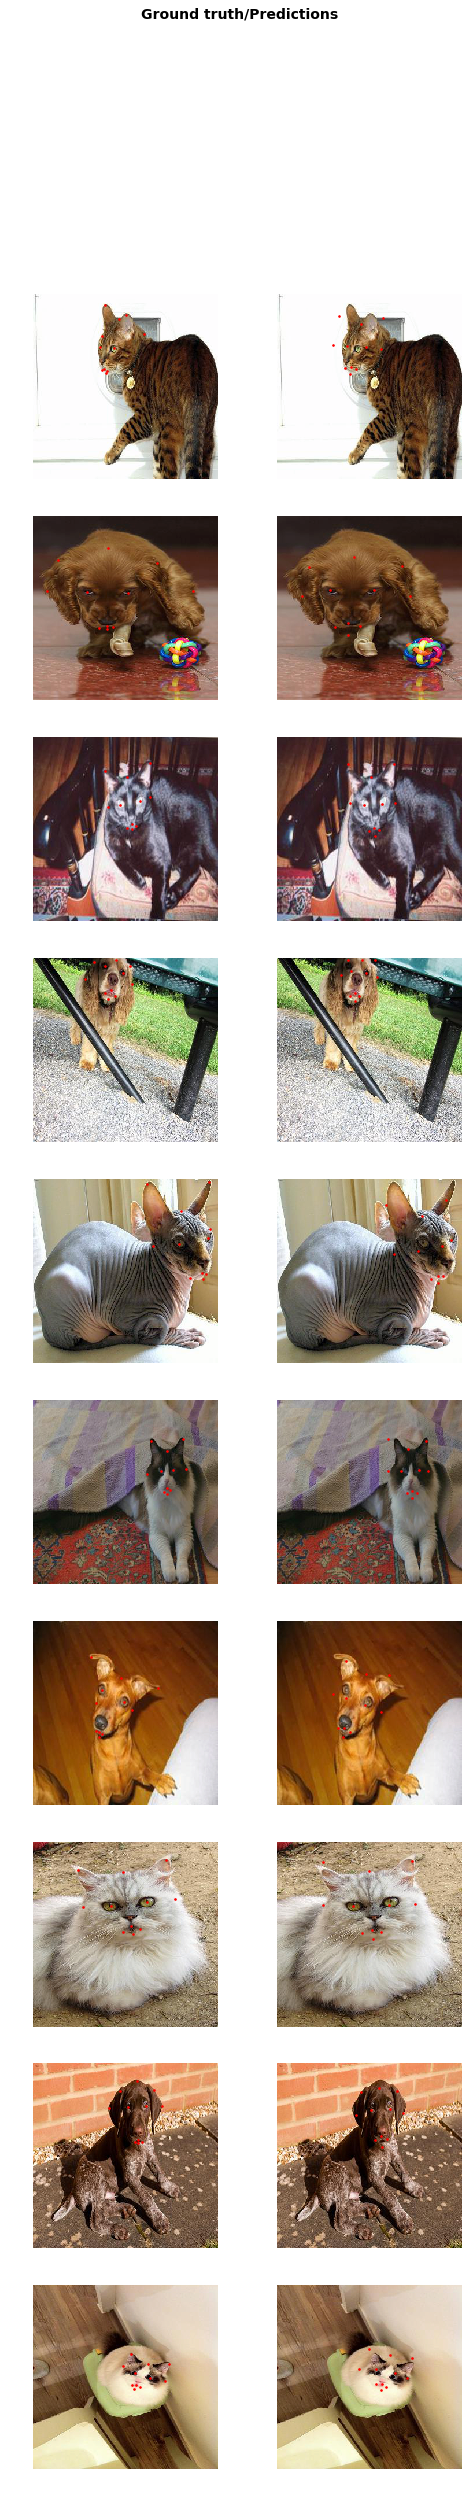

In [17]:
learn.show_results(rows=10)

In [21]:
# img = data.train_ds[0][0]
# preds = learn.predict(img)
# img.show(y=learn.predict(img)[0])